In [1]:
import pandas as pd

In [2]:
# import data from DOH csv file
data = pd.read_csv('DOH COVID Data Drop_ 20200808 - 04 Case Information.csv')
data = data[data['RegionRes']=='NCR']

In [3]:
# selects only important info and drops the null values
data = data[['Age', 'Sex', 'DateRepConf', 'RegionRes']]
#data.dropna()

In [4]:
# sorts the data by confirm date
data = data.sort_values(by='DateRepConf', ascending=True)

In [5]:
data

,Age,Sex,DateRepConf,RegionRes
121464,48.0,MALE,2020-03-06,NCR
105295,33.0,MALE,2020-03-08,NCR
116310,39.0,MALE,2020-03-08,NCR
6313,86.0,MALE,2020-03-08,NCR
110548,72.0,MALE,2020-03-09,NCR
...,...,...,...,...
3213,32.0,MALE,2020-08-08,NCR
4539,37.0,MALE,2020-08-08,NCR
3212,21.0,FEMALE,2020-08-08,NCR
3183,68.0,FEMALE,2020-08-08,NCR


In [6]:
# creates a list of quarantine status
from datetime import datetime
date_format = "%Y-%m-%d"

noq_start,noq_end = "2020-03-06","2020-04-30"
ecq_start,ecq_end = "2020-05-01","2020-05-15"
mecq_start,mecq_end = "2020-05-16","2020-05-31"
gcq_start,gcq_end = "2020-06-01","2020-08-03"
mecq2_start,mecq2_end = "2020-08-04","2020-08-08"

q_status = list()

def quarantine_period(date):
    if datetime.strptime(ecq_start, date_format) <= datetime.strptime(date,date_format) <= datetime.strptime(ecq_end, date_format):
        return "ECQ"
    elif datetime.strptime(gcq_start, date_format) <= datetime.strptime(date,date_format) <= datetime.strptime(gcq_end, date_format):
        return "GCQ"
    elif datetime.strptime(mecq_start, date_format) <= datetime.strptime(date,date_format) <= datetime.strptime(mecq_end, date_format):
        return "MECQ1"
    elif datetime.strptime(date,date_format) >= datetime.strptime(mecq2_start, date_format):
        return "MECQ2"
    else:
        return "No Quarantine"

for i in data['DateRepConf']:
    q_status.append(quarantine_period(i))

In [7]:
# adding the list to the existing data frame
data['QuarantineStat'] = q_status

[Text(0, 0.5, 'Total Cases'), Text(0.5, 0, 'Quarantine Status')]

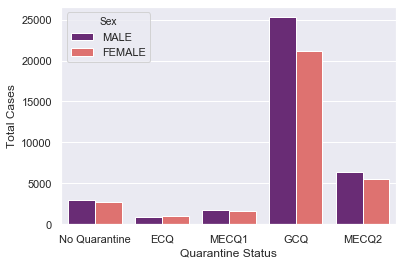

In [8]:
# plot the number of total cases each quarantine stat
import seaborn as sns
sns.set(style="darkgrid")

ax = sns.countplot(x="QuarantineStat", hue="Sex", data=data, palette="magma")
ax.set(xlabel='Quarantine Status', ylabel='Total Cases')

DON'T FORGET TO CHANGE MECQ2_END IF YOU'RE GONNA UPDATE THE DATA SET

In [9]:
# creates chi-square function
q_start, q_end = [ecq_start,gcq_start,mecq_start,mecq2_start,noq_start], [ecq_end,gcq_end,mecq_end,mecq2_end,noq_end]
q_dates = list()
observed = data['QuarantineStat'].value_counts().sort_index() 
expected = list()

for q in zip(q_start,q_end,observed,observed):
    delta = datetime.strptime(q[1], date_format) - datetime.strptime(q[0], date_format)
    q_dates.append(delta.days + 1)
    
for i in q_dates:
    exp = sum(data['QuarantineStat'].value_counts())*(i/sum(q_dates))
    expected.append(exp)
    
def chi(observed,expected):
    chi = sum(abs(observed-expected)**2/expected)
    return chi
    
chi(observed,expected)

74113.18625789032

# SECTION 2: CHI-SQUARE TEST 

In [10]:
# creates new data frame for accumulative cases

df = pd.DataFrame(data['DateRepConf'].value_counts().reset_index().values, columns = ['DateRepConf', 'Cases'])
df = df.sort_values(by='DateRepConf')

total_cases, date_ordinal, q_status = list(), list(), list()
prev = 0

for c in df['Cases']:
    prev += c
    total_cases.append(prev)
    
for i in df['DateRepConf']:
    q_status.append(quarantine_period(i))
    date = datetime.strptime(i, '%Y-%m-%d').date().toordinal()
    date_ordinal.append(date)
    
df['TotalCases'] = total_cases
df['QuarantineStat'] = q_status
df['DateOrdinal'] = date_ordinal

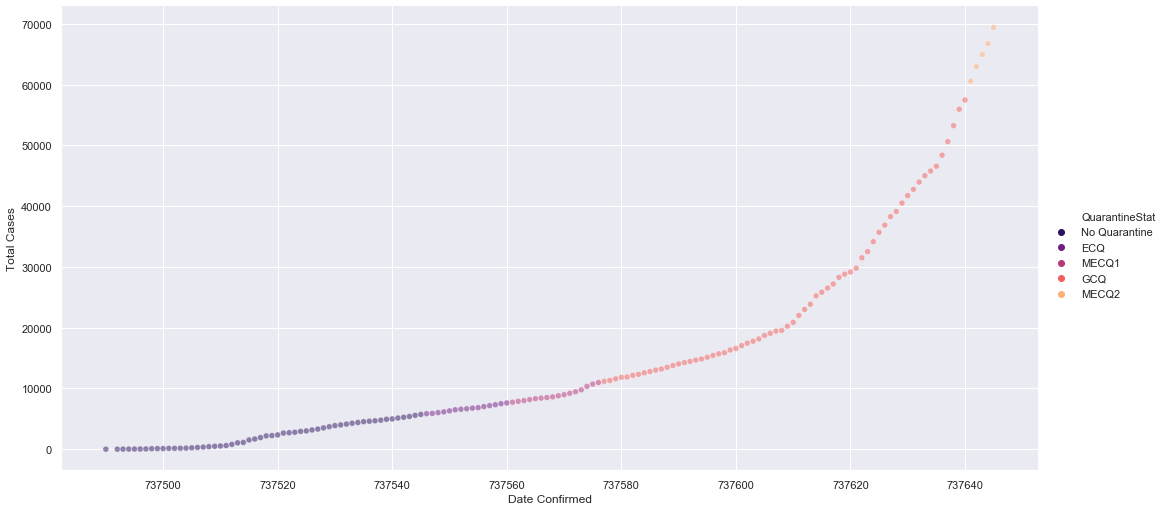

In [11]:
# graphing the accumulated cases
import matplotlib.pyplot as plt

chi_plot = sns.relplot(x="DateOrdinal", y="TotalCases", hue="QuarantineStat", alpha=.5,
            palette="magma", data=df, height=7.27, aspect=10.7/5.27)
chi_plot.set(xlabel="Date Confirmed", ylabel="Total Cases")

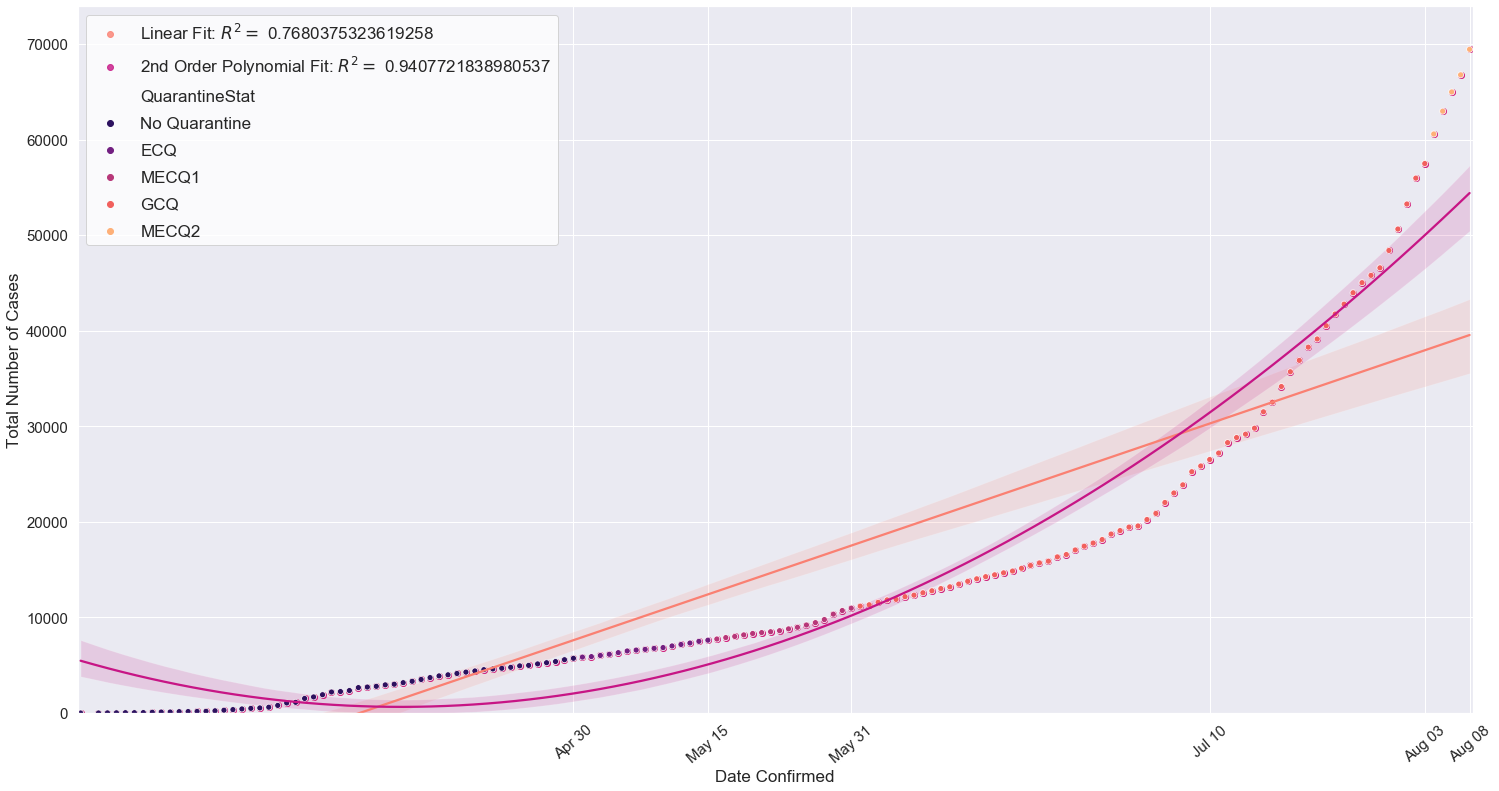

In [12]:
# adding linear fit and 2nd order fit in the graph
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import numpy as np

# training_data (x, y)
X_lin =  df['DateOrdinal'].values[:,np.newaxis]
y_lin = df['TotalCases'].values

# fitting the data
linreg = LinearRegression()  # Initiates linear model
linreg.fit(X_lin,y_lin)

# para maayos yung xticks
x_ticks = [#datetime.strptime('2020-03-20', '%Y-%m-%d').date().toordinal(),
           #datetime.strptime('2020-04-09', '%Y-%m-%d').date().toordinal(),
           #datetime.strptime('2020-06-20', '%Y-%m-%d').date().toordinal(),
           datetime.strptime('2020-07-10', '%Y-%m-%d').date().toordinal(),
           datetime.strptime(noq_end, '%Y-%m-%d').date().toordinal(),
           datetime.strptime(ecq_end, '%Y-%m-%d').date().toordinal(),
           datetime.strptime(mecq_end, '%Y-%m-%d').date().toordinal(),
           datetime.strptime(gcq_end, '%Y-%m-%d').date().toordinal(),
           datetime.strptime(mecq2_end, '%Y-%m-%d').date().toordinal()]

x_ticks_def = [#datetime.strptime('2020-03-20', '%Y-%m-%d').date().strftime("%b %d"),
               #datetime.strptime('2020-04-09', '%Y-%m-%d').date().strftime("%b %d"),
               #datetime.strptime('2020-06-20', '%Y-%m-%d').date().strftime("%b %d"),
               datetime.strptime('2020-07-10', '%Y-%m-%d').date().strftime("%b %d"),
               datetime.strptime(noq_end, '%Y-%m-%d').date().strftime("%b %d"),
               datetime.strptime(ecq_end, '%Y-%m-%d').date().strftime("%b %d"),
               datetime.strptime(mecq_end, '%Y-%m-%d').date().strftime("%b %d"),
               datetime.strptime(gcq_end, '%Y-%m-%d').date().strftime("%b %d"),
               datetime.strptime(mecq2_end, '%Y-%m-%d').date().strftime("%b %d")]

#date_ordinal_sub = [datetime.strptime(i, '%Y-%m-%d').date().strftime('%b %d') for i in df['DateRepConf']]

""" should use lower order when order=3 is initialized
reason:
Note that fitting polynomial coefficients is inherently badly conditioned when the degree of 
the polynomial is large or the interval of sample points is badly centered. The quality of the
fit should always be checked in these cases. When polynomial fits are not satisfactory, splines may be a good alternative.
"""

# calculates R^2
# reshapes the x and y data for scikit cause need nya ng array not list
x = np.array(df['DateOrdinal']).reshape((-1, 1))
y = np.array(df['TotalCases']).reshape((-1, 1))

# linear regression
linreg = LinearRegression()
linreg.fit(x,y)
lin_eq = ["$R^2 =$", str(linreg.score(x,y))]

# polynomial reg (degree = 2)
p2 = np.polyfit(date_ordinal, df['TotalCases'],2)
poly2 = PolynomialFeatures(degree = 2)
y2_predict = np.polyval(p2,date_ordinal)
poly2_eq = ["$R^2 =$", str(r2_score(y,y2_predict))]

# plotting the figure
plt.figure(figsize=(25,13))
order1 = sns.regplot(X_lin, y_lin, order=1, color='salmon', label="Linear Fit: " + " ".join(lin_eq))
order2 = sns.regplot(X_lin, y_lin, order=2, color='mediumvioletred', label="2nd Order Polynomial Fit: " + " ".join(poly2_eq))
#order3 = sns.regplot(X_lin, y_lin, order=3, color='mediumvioletred', label="3rd Order Polynomial Fit")  

#orderlog = sns.regplot(X_lin, y_lin, logistic=True, color='blue', label="Logistic Fit")
scatter = sns.scatterplot(x="DateOrdinal", y="TotalCases", hue="QuarantineStat", data=df, palette="magma")
plt.xticks(x_ticks, x_ticks_def, rotation=40, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Date Confirmed", fontsize = 17)
plt.ylabel("Total Number of Cases", fontsize = 17)
plt.ylim(bottom=0)

plt.legend(labelspacing=0.7,  prop={'size': 17}, facecolor='white')
plt.show()

Calculating the chi-square

chi2 = SUM(ABS(Observed-Expected)^2/Expected)

In [52]:
bin_dates = ["2020-04-30","2020-05-15","2020-05-31","2020-07-10","2020-08-08"]

def chi_square(bin_dates,fit):
    
    x_date = [np.array(df[df['DateRepConf']==i].iloc[0]['DateOrdinal']).reshape((-1, 1)) for i in bin_dates]
    observed = [np.array(df[df['DateRepConf']==i].iloc[0]['TotalCases']).reshape((-1, 1)) for i in bin_dates]
    
    if fit == "linear":
        expected = [linreg.predict(i) for i in x_date]
    else:
        expected = np.polyval(p2,x_date)
        
    chi_each = [np.absolute(i[0]-i[1])**2/i[1] for i in zip(observed,expected)]
    chi = np.sum(chi_each)
    return chi
    

In [61]:
chi_square(bin_dates, fit = "linear")
chi_square(bin_dates, fit = "notlinear")

12894.09828261739